# **이상탐지2: 수업실습용**

## **1. 라이브러리 로드**

In [57]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 
%matplotlib inline

# 데이터 전처리 패키지
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

# 모델 패키지
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf

# 모델 평가 패키지
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score


# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# 마이너스 기호(-) 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# # 한글 폰트 사용하기
# plt.rc('font', family='Malgun Gothic')

----------------------------------------------------------------------------------

## **2. 이상치 데이터 셋 임의로 생성**

- make_blobs: 서로 다른 클러스터를 형성하는 데이터를 생성하는 함수
- 입력 매개변수:
    - n_samples: 생성할 데이터 포인트의 수.
    - n_features: 각 데이터 포인트의 특성(차원) 수.
    - centers: 클러스터의 중심 수 또는 중심의 좌표.
    - cluster_std: 각 클러스터의 표준 편차로, 클러스터의 분산 정도를 조절합니다.
    - random_state: 난수 생성 시드로, 동일한 결과를 재현할 수 있도록 합니다.

train 데이터셋 생성

In [58]:
# 정상 데이터 생성
X_normal_train, y_normal_train = make_blobs(n_samples=1000, centers=1, n_features=5, cluster_std=1, random_state=0, center_box=(5,9))
df_normal_train = pd.DataFrame(X_normal_train, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_normal_train['anomaly_indicator']=0

# 이상 데이터 생성
X_abnormal_train, y_abnormal_train = make_blobs(n_samples=100, centers=2, n_features=5, cluster_std=10, random_state=0, center_box=(10,12))
df_abnormal_train = pd.DataFrame(X_abnormal_train, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_abnormal_train['anomaly_indicator']=1
# 이상 데이터, 정상데이터 combine
df_train = pd.concat([df_normal_train, df_abnormal_train])

test 데이터셋 생성

In [59]:
# 정상 데이터 생성
X_normal, y_normal = make_blobs(n_samples=200, centers=1, n_features=5, cluster_std=1, random_state=0, center_box=(5,9))
df_normal = pd.DataFrame(X_normal, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_normal['anomaly_indicator']=0

# 이상 데이터 생성
X_abnormal, y_abnormal = make_blobs(n_samples=20, centers=2, n_features=5, cluster_std=10, random_state=0, center_box=(10,12))
df_abnormal = pd.DataFrame(X_abnormal, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_abnormal['anomaly_indicator']=1

# 이상 데이터, 정상데이터 combine
df = pd.concat([df_normal, df_abnormal])

In [60]:
# 데이터셋 확인
# defaut로 앞에서 5개의 데이터를 출력
df.head()

,x1,x2,x3,x4,x5,anomaly_indicator
0,7.299190,7.031186,7.903813,7.269646,5.697052,0
1,7.881233,6.241004,6.558528,7.566263,7.605359,0
2,6.933582,7.681378,6.718283,8.317360,6.525462,0
3,7.401804,6.955763,8.065552,7.640864,5.040028,0
4,8.409498,7.286542,5.288103,8.304289,6.806680,0


In [61]:
# 데이터셋 크기 확인
print("train dataset:", df_train.shape)
print("test dataset:", df.shape)

train dataset: (1100, 6)
test dataset: (220, 6)


In [62]:
# X 값 확인
df[df.columns.difference(['anomaly_indicator'])]


,x1,x2,x3,x4,x5
0,7.299190,7.031186,7.903813,7.269646,5.697052
1,7.881233,6.241004,6.558528,7.566263,7.605359
2,6.933582,7.681378,6.718283,8.317360,6.525462
3,7.401804,6.955763,8.065552,7.640864,5.040028
4,8.409498,7.286542,5.288103,8.304289,6.806680
...,...,...,...,...,...
15,4.567184,7.279643,3.652083,-5.335501,12.541144
16,30.123295,-2.602416,-0.921304,21.621293,-0.964351
17,30.250680,22.662970,9.984298,1.219799,21.311400
18,-3.446030,11.887964,9.333688,26.417559,25.540897


<Axes: xlabel='x1', ylabel='x2'>

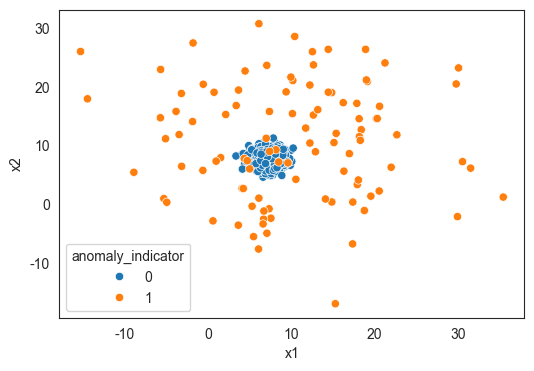

In [63]:
# 데이터 시각화 (임의 변수 선택)
plt.figure(figsize=(6, 4))
sns.scatterplot(x='x1', y='x2', hue='anomaly_indicator', data=df_train)

<Axes: xlabel='x1', ylabel='x2'>

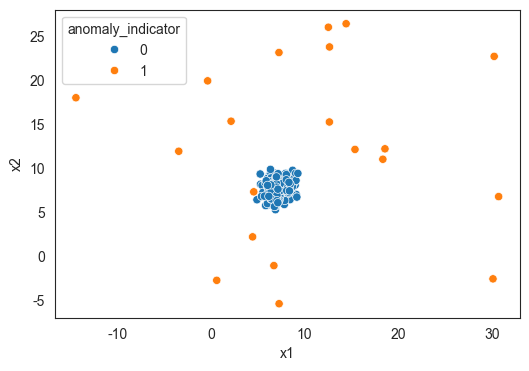

In [64]:
# 데이터 시각화 (임의 변수 선택)
plt.figure(figsize=(6, 4))
sns.scatterplot(x='x1', y='x2', hue='anomaly_indicator', data=df)

----------------------------------------------------------------------------------

## **3. 탐색적 데이터 분석(EDA)**

### **3-1. 데이터의 변수별 분포 확인**

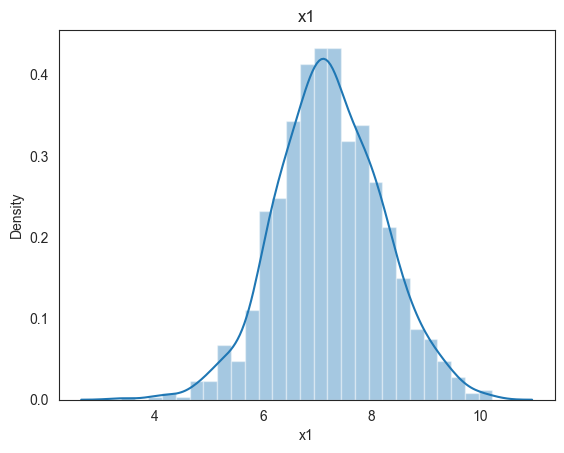

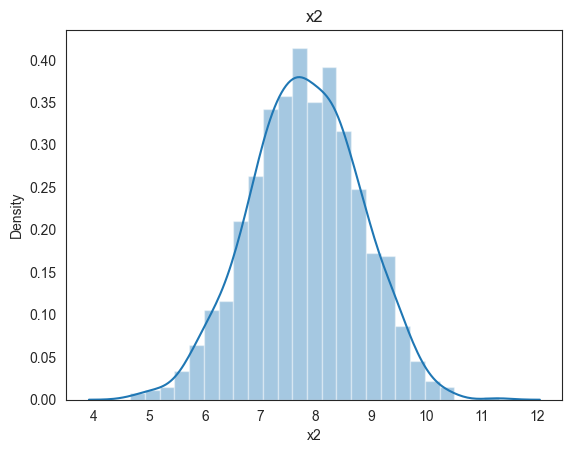

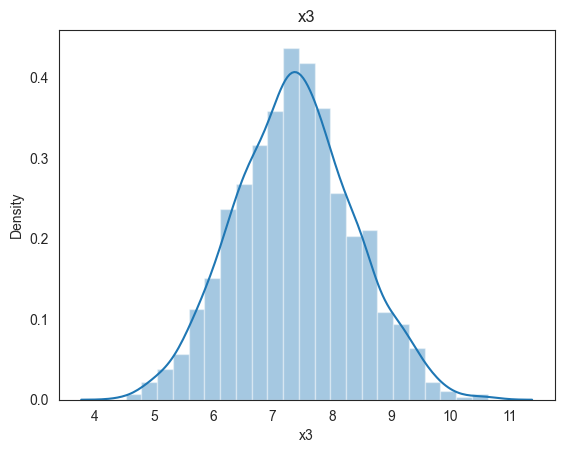

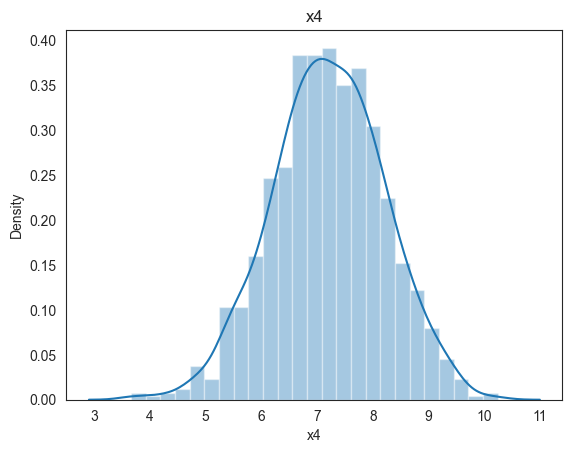

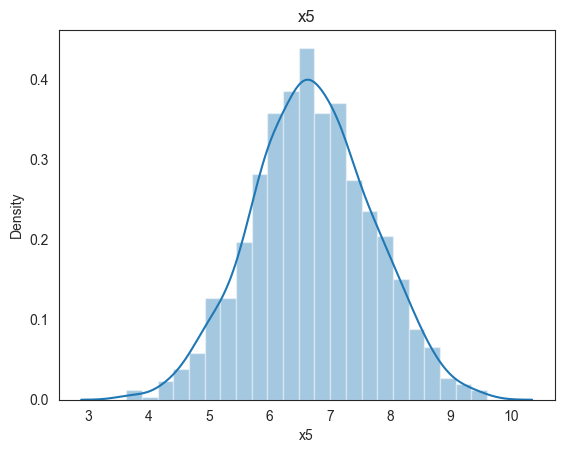

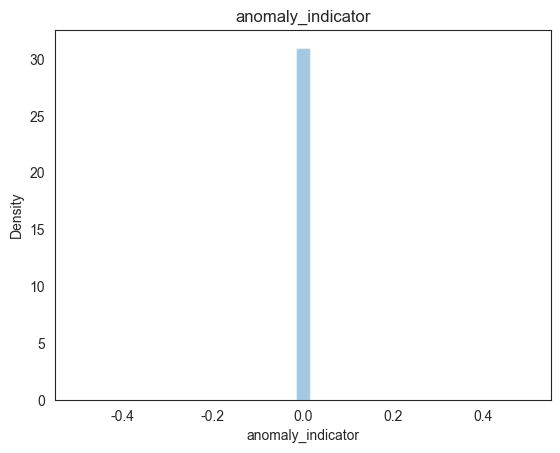

In [65]:
# 정상 데이터의 변수별 분포 확인
for col in df_train.columns:
    sns.distplot(df_normal_train.loc[df_normal_train[col].notnull(), col])
    plt.title(col)
    plt.show()

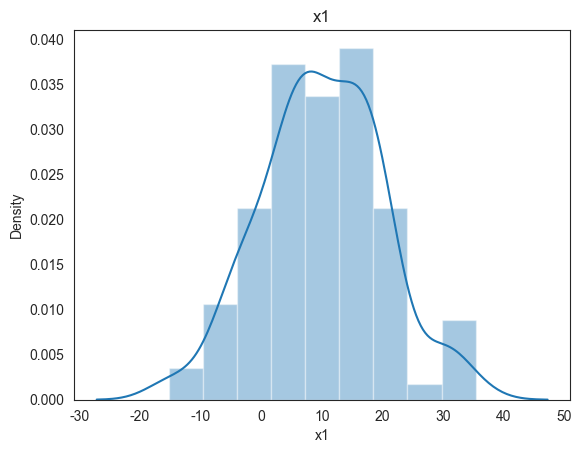

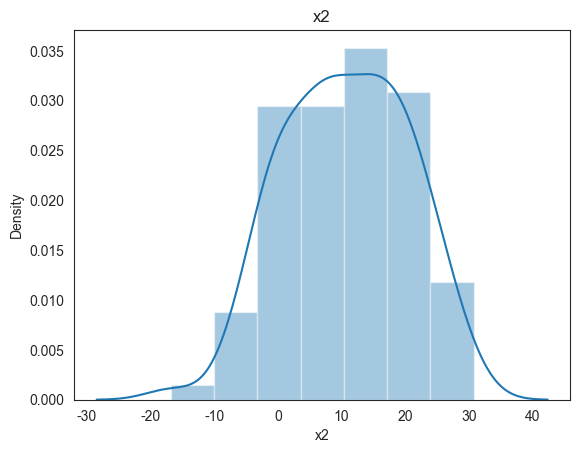

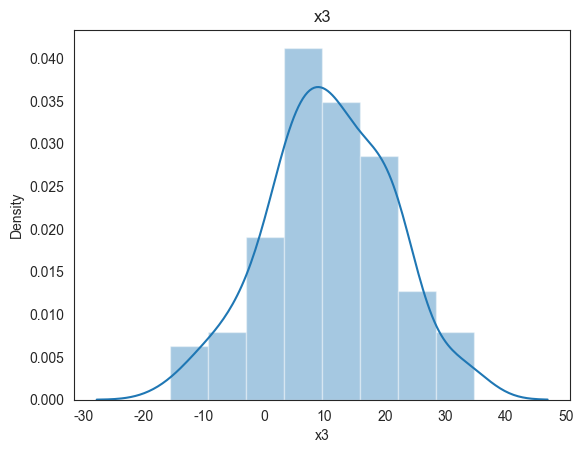

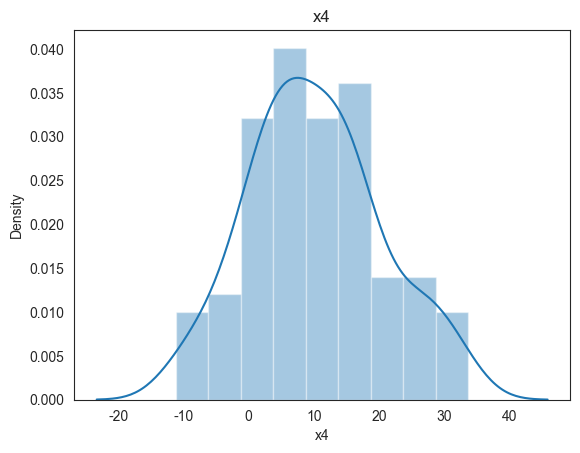

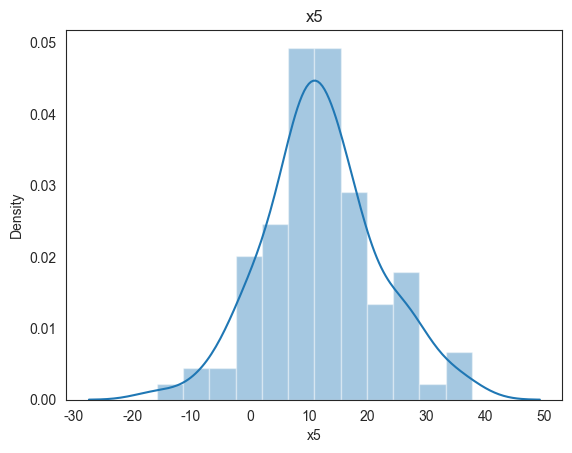

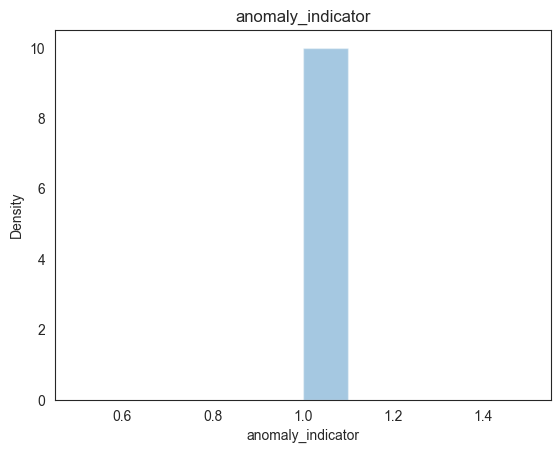

In [66]:
# 이상 데이터의 변수별 분포 확인
for col in df_train.columns:
    sns.distplot(df_abnormal_train.loc[df_abnormal_train[col].notnull(), col])
    plt.title(col)
    plt.show()

### **3-2. 정상 데이터와 이상 데이터의 클래스 수 비교**

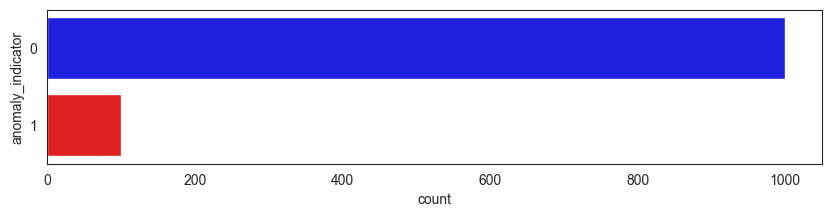

In [67]:
# 정상 데이터와 이상 데이터 클래수 비교
plt.figure(figsize=(10,2))
fig = sns.countplot(y=df_train['anomaly_indicator'], data=df_train, palette=["blue", "red"])
plt.show()

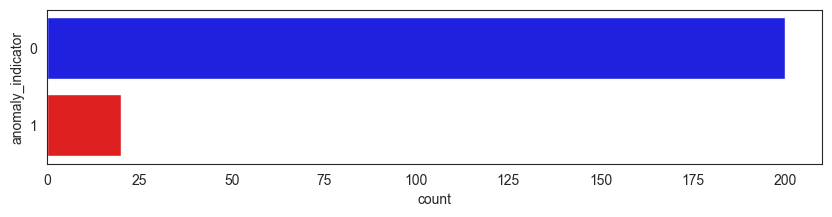

In [68]:
# 정상 데이터와 이상 데이터 클래수 비교
plt.figure(figsize=(10,2))
fig = sns.countplot(y=df['anomaly_indicator'], data=df, palette=["blue", "red"])
plt.show()

----------------------------------------------------------------------------------

## **4. 데이터 전처리**

### **4-1. train, validation test 데이터셋 생성**
- train 데이터: 정상 데이터
- test 데이터: 정상 + 이상 데이터

In [69]:
# train 데이터 셋 => X_train, y_train 분할
X_train = df_train[df_train.columns.difference(['anomaly_indicator'])]
y_train = df_train["anomaly_indicator"]

# test 데이터 셋 => X_test, y_test 분할
X_test = df[df.columns.difference(['anomaly_indicator'])]
y_test = df["anomaly_indicator"]

----------------------------------------------------------------------------------

## **5. 모델 구축**

### 5-1. Decision Tree 기반의 앙상블 기법 이상탐지 모델: Isolation Forest
- 여러 개의 의사결정나무를 종합한 앙상블 기반의 이상탐지 기법으로 의사결정나무를 지속적으로 분기시키면서 모든 데이터 관측치의 고립 정도 여부에 따라 이상치를 판별
- 대규모 데이터셋에 잘 작동하며, 비선형 데이터에도 유연하게 적용
> 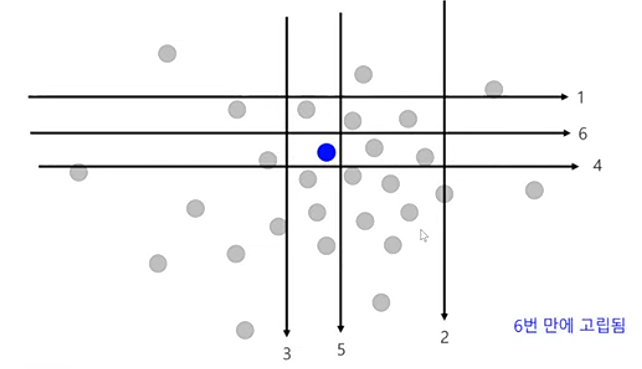
> 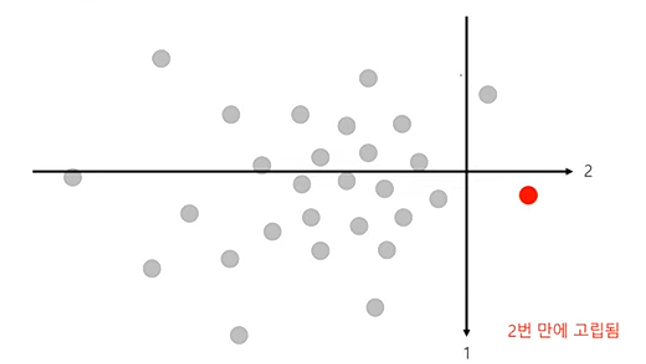
  
- 빠르게 고립됨: 이상치일 확률이 높음

In [70]:
# Isolation Forest 모델 구축
IForest = IForest()
IForest.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [71]:
# train data에 대한 예측 값(정상=0, 이상=1)
IForest_train_pred = IForest.predict(X_train) 
# test data에 대한 예측 값(정상=0, 이상=1)
IForest_test_pred = IForest.predict(X_test) 

accuracy:  0.990909090909091
recall:  1.0
precision:  0.909
f1-score:  0.952


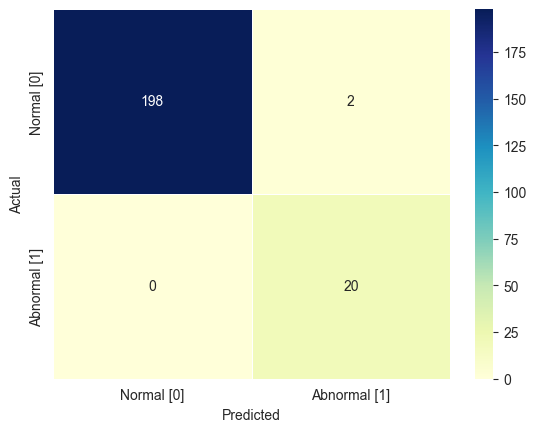

In [72]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, IForest_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, IForest_test_pred))
print("recall: ", round(recall_score(y_test, IForest_test_pred),3))
print("precision: ", round(precision_score(y_test, IForest_test_pred),3))
print("f1-score: ", round(f1_score(y_test, IForest_test_pred),3))

### **5-2. 밀도기반 이상탐지 모델: Local Outlier Factor**
- 각각의 관측치가 데이터 안에서 얼마나 벗어나 있는가에 대한 정도(이상치 정도)를 의미
    - **모든 데이터를 전체적으로 고려하는 것이 아닌, 해당 관측치의 주변 데이터(neighbor)를 이용하여 국소적(local) 관점으로 이상치 정도를 파악**
- 지역적인 밀도 차이를 고려하기 때문에, 군집 구조가 있는 데이터에서도 효과적으로 작동
  
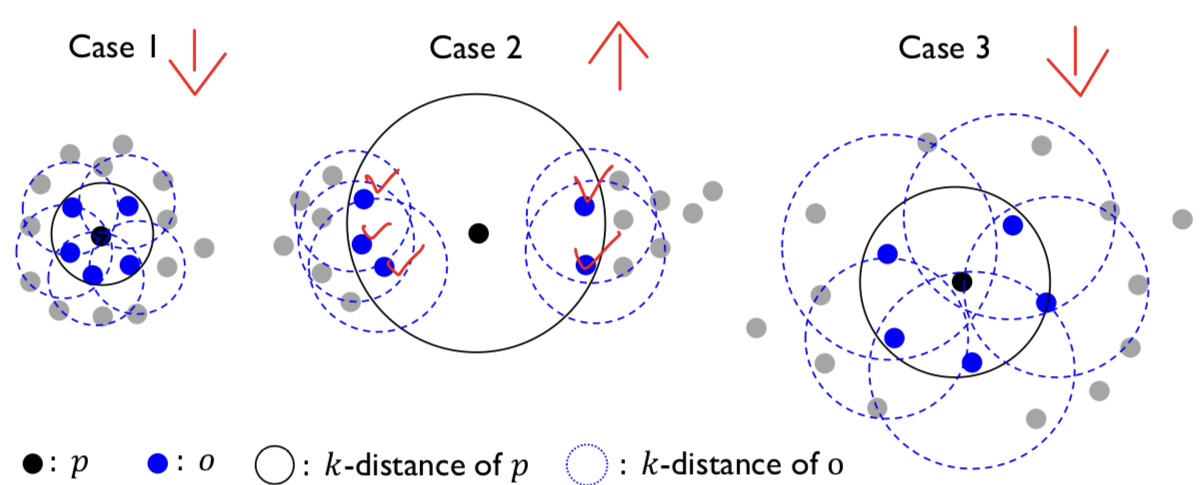
  
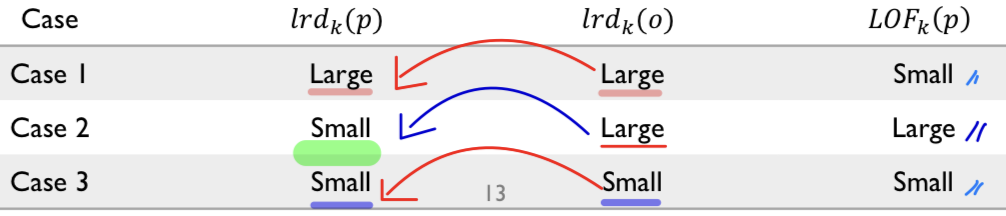
  
- 밀도가 높은 영역 사이에 낮은 밀도를 가진 객체를 이상치로 정의

In [73]:
# LOF 모델 구축
LOF = LocalOutlierFactor(contamination=0.1,novelty=True)
LOF.fit(X_train)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [74]:
# train data에 대한 예측 값(정상=1, 이상=-1)
LOF_train_pred = LOF.predict(X_train) 
LOF_train_pred

# test data에 대한 예측 값(정상=1, 이상=-1)
LOF_test_pred = LOF.predict(X_test) 
LOF_test_pred = pd.DataFrame(LOF_test_pred)
# test data에 대한 예측 값(정상=0, 이상=1)으로 변경
LOF_test_pred = LOF_test_pred.replace({-1: 1, 1: 0})
LOF_test_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
215,1
216,1
217,1
218,1


accuracy:  0.9636363636363636
recall:  0.75
precision:  0.833
f1-score:  0.789


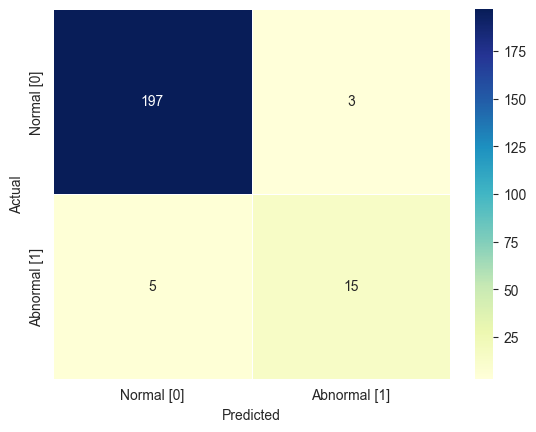

In [75]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, LOF_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, LOF_test_pred))
print("recall: ", round(recall_score(y_test, LOF_test_pred),3))
print("precision: ", round(precision_score(y_test, LOF_test_pred),3))
print("f1-score: ", round(f1_score(y_test, LOF_test_pred),3))

### **5-3,4. 재구축 기반 이상탐지 모델**
- 원본 데이터를 압축했다가 다시 원본과 같은 차원으로 복원하는 과정에서 재구축 오차를 통해 이상치 탐색
- 이상 관측치들은 잘 복원되지 않을 것이라는 가정
  
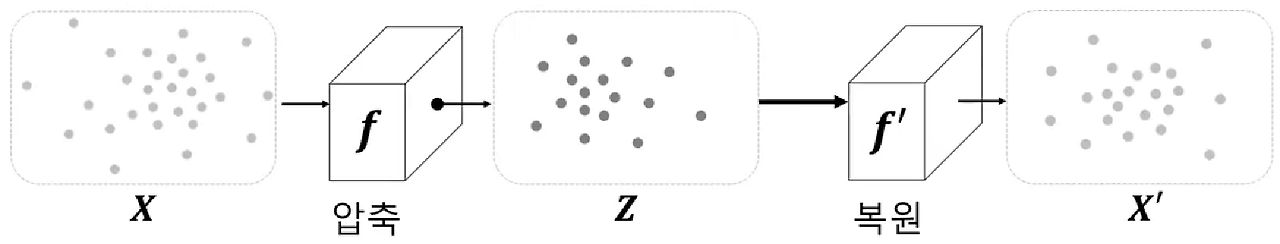

### **5-3. 재구축 기반 이상탐지 모델: Pricipal Component Analysis(PCA)**
- 고차원 데이터에서 이상치를 탐지하는 데 효과적
  
> 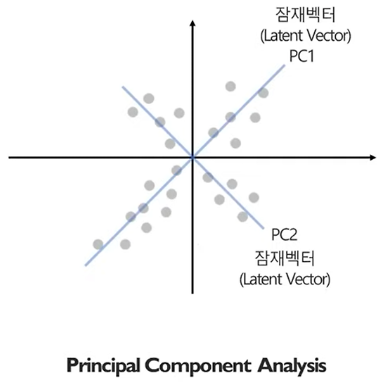
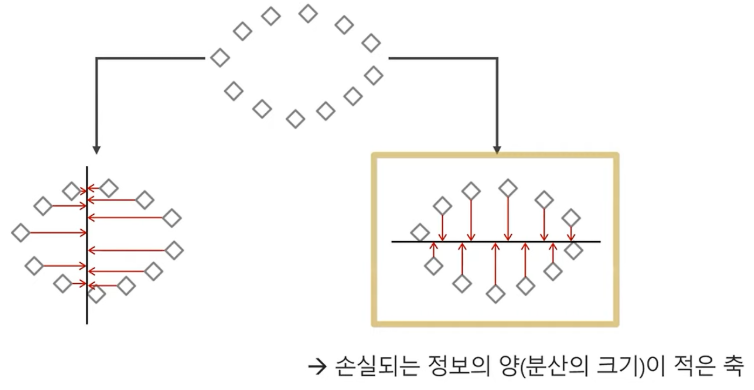

In [76]:
PCA = PCA()
PCA.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [77]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_train_pred = PCA.predict(X_train) 

# test data에 대한 예측 값(정상=0, 이상=1)
PCA_test_pred = PCA.predict(X_test) 

accuracy:  0.9954545454545455
recall:  1.0
precision:  0.952
f1-score:  0.976


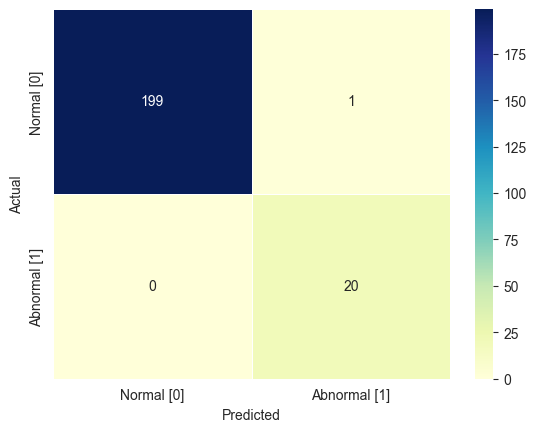

In [78]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, PCA_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, PCA_test_pred))
print("recall: ", round(recall_score(y_test, PCA_test_pred),3))
print("precision: ", round(precision_score(y_test, PCA_test_pred),3))
print("f1-score: ", round(f1_score(y_test, PCA_test_pred),3))

### **5-4. 재구축 기반 이상탐지 모델: Auto-Encoder**
- 복잡한 비선형 관계를 모델링하며 비지도 기반의 학습
  
> 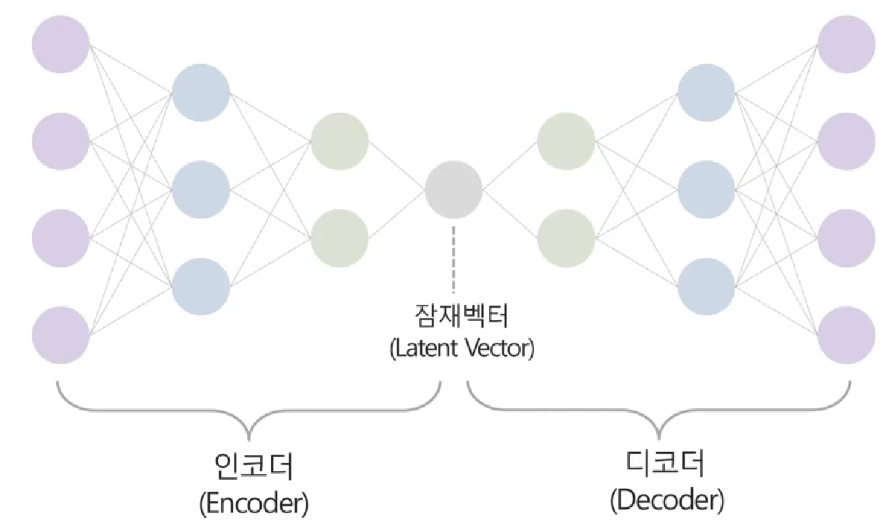

In [79]:
input_dim = X_train.shape[1]

AE = tf.keras.models.Sequential([
    
    # encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

AE.compile(optimizer="adam", loss="mse")
AE.summary();

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
history = AE.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 53.0735 - val_loss: 101.5009
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.0291 - val_loss: 99.8733
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.3201 - val_loss: 98.1893
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.2345 - val_loss: 96.4191
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.6816 - val_loss: 94.5462
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.9151 - val_loss: 92.6268
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.0917 - val_loss: 90.6723
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.6034 - val_loss: 88.6545
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.6630 - val_loss: 86.6705
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39.2949 - val_loss: 84.7807
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.7732 - val_loss: 82.9775
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━

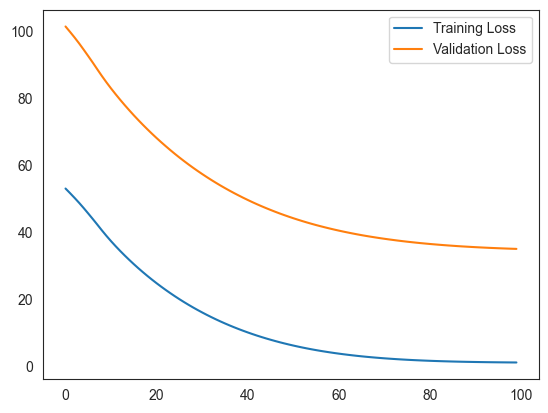

In [81]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [82]:
# train data에 대한 예측 값
AE_train_pred = AE.predict(X_train)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의 -> Novelty Score
train_mse = np.mean(np.power(X_train - AE_train_pred, 2), axis=1)
train_mse = pd.DataFrame({'Reconstruction_error': train_mse})
train_mse

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Reconstruction_error
0,0.305009
1,0.967692
2,2.275657
3,0.554548
4,0.975363
...,...
95,294.298653
96,55.563089
97,95.917348
98,176.019621


In [83]:
# train 데이터에 대한 novelty score 기준 상위 10% 의 값을 임계치로 설정
AE_thresh = np.percentile(sorted(train_mse['Reconstruction_error']), 90)
AE_thresh

np.float64(3.132297269353155)

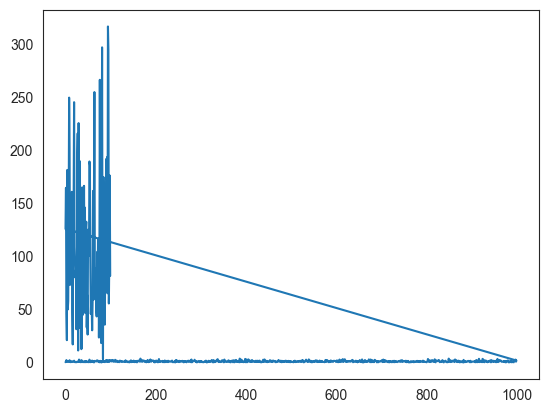

In [84]:
plt.plot(train_mse)

In [85]:
# test data에 대한 예측 값
AE_test_pred = AE.predict(X_test)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의
test_mse = np.mean(np.power(X_test - AE_test_pred, 2), axis=1)
test_mse

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


0       0.345357
1       0.731907
2       0.340410
3       0.782963
4       1.268221
         ...    
15     41.571063
16    192.401823
17    207.634108
18    174.607237
19    109.137464
Length: 220, dtype: float64

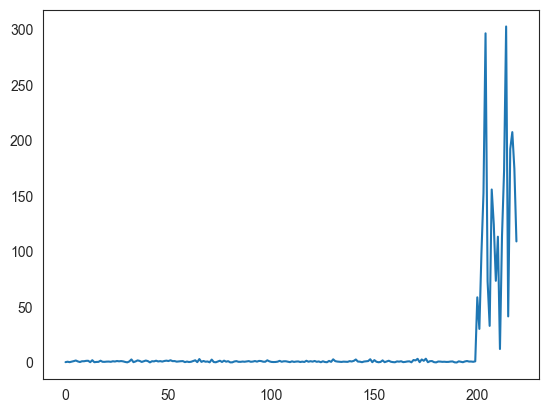

In [86]:
plt.plot(test_mse.values)

In [87]:
# classifier
# AE_thresh 기준, test_mse 값이 더 크면 이상(1), 작으면 정상(0)으로 분류
AE_test_df = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > AE_thresh:
            AE_test_df.append(1)
        else:
            AE_test_df.append(0)

In [88]:
novelty_classifier(test_mse.values)

accuracy:  0.990909090909091
recall:  1.0
precision:  0.909
f1-score:  0.952


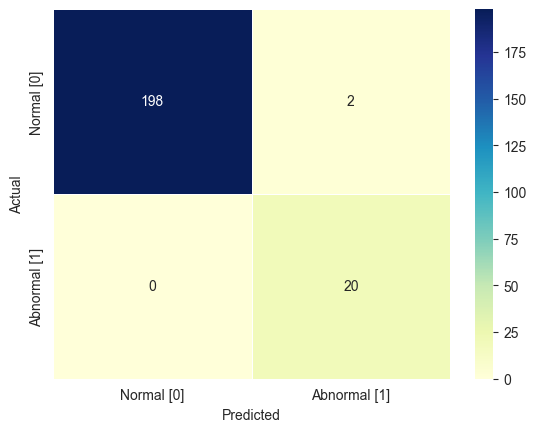

In [89]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, AE_test_df) #confusion_matrix 함수 실행

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, AE_test_df))
print("recall: ", round(recall_score(y_test, AE_test_df),3))
print("precision: ", round(precision_score(y_test, AE_test_df),3))
print("f1-score: ", round(f1_score(y_test, AE_test_df),3))